# Scaffold clustering

We have seen that simplifying almost 7000 into cca 1500 scaffolds doesn't bring huge loss of information. Now we try to go to the next level and simplify the scaffolds by clustering them together.

In [1]:
# %load_ext rpy2.ipython
# %load_ext RWinOut # hack to see the output, https://github.com/vitorcurtis/RWinOut

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole

from tqdm import tqdm_notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

In [3]:
df_molecules_std.scaffold_smiles.fillna('', inplace=True)

In [4]:
df_scaffolds = df_molecules_std \
    .reset_index() \
    [['scaffold_inchi_key', 'scaffold_smiles', 'scaffold_morgan_fp']] \
    .drop_duplicates('scaffold_inchi_key') \
    .copy()

In [6]:
df_scaffolds['mol'] = list(map(MolFromSmiles, df_scaffolds.scaffold_smiles))

In [7]:
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_scaffolds.scaffold_morgan_fp])

We use euclidean distance and ward metric. I have played with others (e.g. hamming or jaccard distance more suitable for binary vectors) but I foud this setting to be the best.

In [8]:
z = linkage(scaffold_fps, method='ward', metric='euclidean')

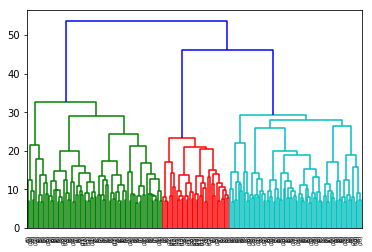

In [9]:
dendrogram(z, truncate_mode='lastp', p=200);

## Choosing the optimal number of clusters

We need to choose where to cut the dendogram.

### The elbow method

We plot the total variance explained against the number of clusters. The optimal number of clusters should be when the plot starts to flatten out (the elbow).

In [10]:
d2 = pairwise_distances(scaffold_fps, metric='euclidean')**2

In [11]:
N = len(scaffold_fps) # number of datapoints
Bs = []  # sum of squares between groups
Ws = []  # sum of squares within groups
T = np.sum(d2)  # total sum of squares
VRC_values = []
clust_sizes = range(2,len(z),1)
real_clust_sizes = []
last_k = -1
for n_clust in tqdm_notebook(clust_sizes):
    labels = fcluster(z, criterion='maxclust', t=n_clust)  # cut the dendogram
    k = len(set(labels))
    if k == last_k:
        continue
    real_clust_sizes.append(k)
    last_k = k
    
    mask = cdist(labels.reshape(-1,1), labels.reshape(-1,1), metric='hamming') # we get 1s where there are different clusters
    B = np.sum(d2*mask)
    W = T - B
    Bs.append(B)
    Ws.append(W)
    VRC = (B/(k-1))/(W/(N-k))
    VRC_values.append(VRC)

    
real_clust_sizes = np.asarray(real_clust_sizes)
VRC_values = np.asarray(VRC_values)
Bs = np.asarray(Bs)
Ws = np.asarray(Ws)

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, '% variance explained')

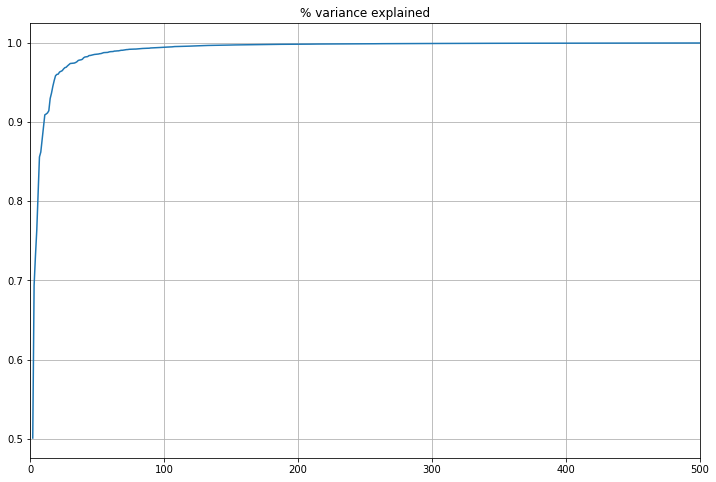

In [12]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, Bs/T)
plt.grid()
plt.xlim(0,500)
plt.title('% variance explained')

We can see some kind of elbow already at ~20 clusters. At 100-200 the plot becomes completely flat.

To see more detail we plot the increase of the explained variance by adding one cluster.

Text(0.5, 1.0, 'delta % variance explained (log scale)')

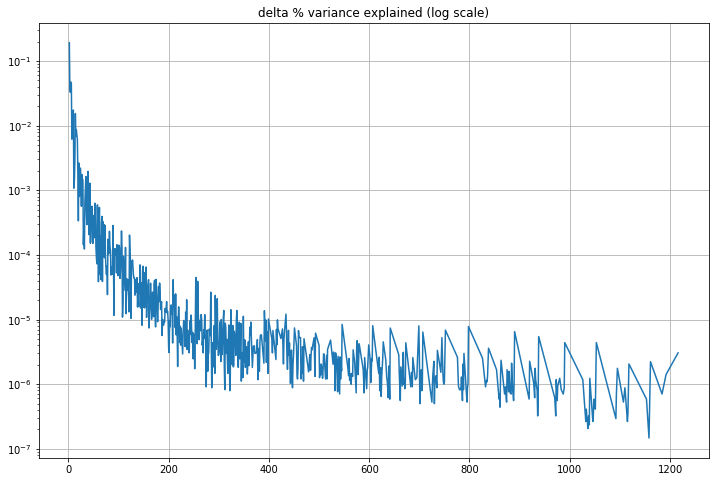

In [13]:
B_ratio = Bs/T
delta_B_ratio = B_ratio[1:] - B_ratio[:-1]
plt.figure(figsize=(12,8))
plt.semilogy(real_clust_sizes[:-1], delta_B_ratio)
plt.grid()
# plt.xlim(0,800)
plt.title('delta % variance explained (log scale)')

We see that from 200 clusters and on, there is only $10^{-5} = 0.001\%$ increase of the explained variance.

### F-statistic method

Some say that the optimal number of clusters is at the maximum of the F-statistics.

I know about two F-statistics, the firs $\frac{BSS/(k-1)}{WSS/(N-k)}$, where between sum of squares (BSS), within sum of squares (WSS) and number of clusters (k) is computed for each k.

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'variance ratio criterion (F-statistic)')

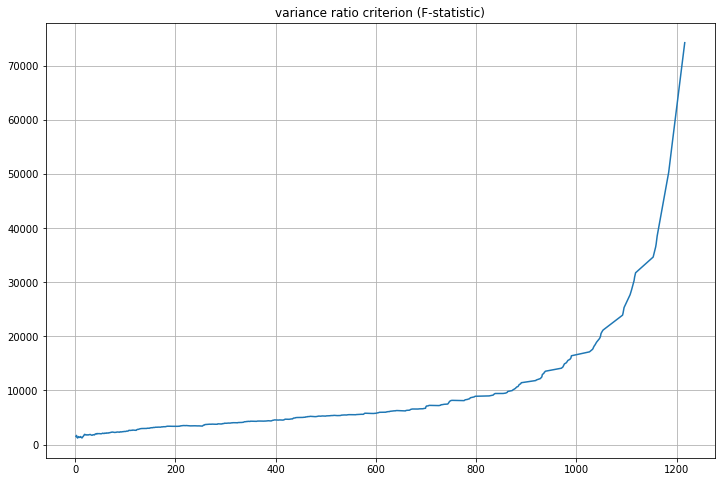

In [14]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, (Bs/(real_clust_sizes-1))/(Ws/(N-real_clust_sizes)))
plt.grid()
# plt.xlim(100,200)
plt.title('variance ratio criterion (F-statistic)')

The other F-statistic is $\frac{BSS/(k-1)}{TSS/(N-1)}$ where TSS is total sum of squares.

Text(0.5, 1.0, 'variance ratio criterion (F-statistic)')

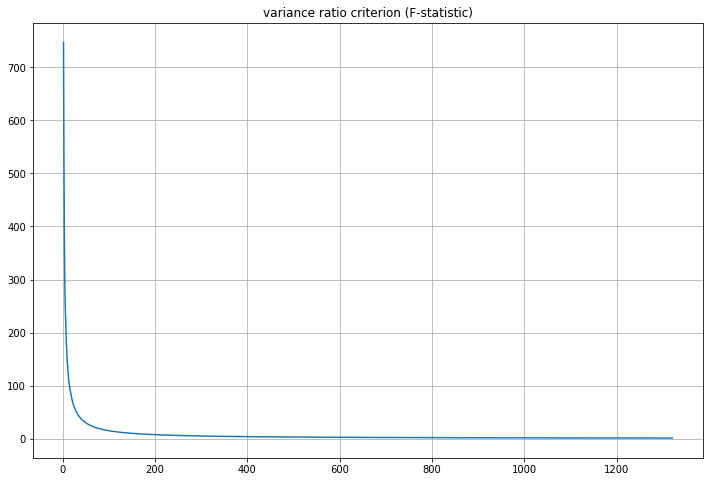

In [15]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, (Bs/(real_clust_sizes-1))/(T/(N-1)))
plt.grid()
# plt.xlim(100,200)
plt.title('variance ratio criterion (F-statistic)')

We see that there are no helpful maxima.

### Silhouette score

In [16]:
sscores = []
clust_sizes = range(2,len(z),1)
real_clust_sizes = []
last_k = -1
dist = pairwise_distances(scaffold_fps, metric='jaccard')
for n_clust in tqdm_notebook(clust_sizes):
    labels = fcluster(z, criterion='maxclust', t=n_clust)
    k = len(set(labels))
    if k == last_k:
#         VRC_values.append(VRC_values[-1])
        continue
    real_clust_sizes.append(k)
    last_k = k
    sscores.append(silhouette_score(dist, labels, metric='precomputed'))
    
sscores = np.asarray(sscores)

f:\programy\Miniconda3\envs\main\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


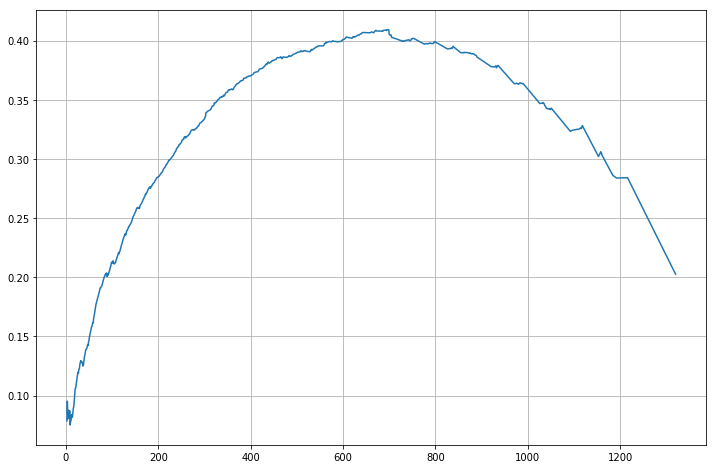

In [38]:
plt.figure(figsize=(12,8))
plt.plot(real_clust_sizes, sscores)
plt.grid()
# plt.xlim(100,200)

In [18]:
n_clust_opt = real_clust_sizes[np.argmax(sscores)]
print('The optimal number of clusters is', n_clust_opt)

The optimal number of clusters is 695


## Clustering visualization

The plots above are indecisive - the silhouette has a clear maximum around 700, but the elbow plot is very flat since 150 while the F-statistics have maxima at maximum number of clusters. So based on the elbow plot and the following visualizations I have picked 200 clusters.

In [19]:
n_clust = 200
labels = fcluster(z, criterion='maxclust', t=n_clust)
display(np.max(labels))
label_names = np.asarray(['cluster_'+str(x) for x in labels])
df_scaffolds['cluster_label'] = label_names

200

Text(0.5, 1.0, 'Distribution of cluster sizes')

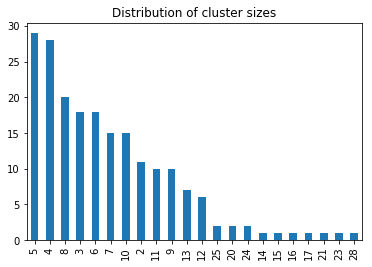

In [20]:
pd.Series(labels).value_counts().value_counts().plot(kind='bar')
plt.title('Distribution of cluster sizes')

We can se we don't have any singletons, the majority of clusters are of size 3-10.

In [21]:
scaffolds_pca = PCA(2).fit_transform(scaffold_fps)
scaffold_mds = MDS(eps=1e-1, max_iter=50).fit_transform(scaffold_fps)
scaffolds_tsne = TSNE().fit_transform(scaffold_fps)

In [22]:
def make_colormap_cycle(x):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    return [colors[a%len(colors)] for a in x]

We plot the space of the fingerprints embeded to 2d in three different ways. The points are colored by the cluster they belong to. Note however that there are only 10 different colors for those 200 clusters, so the same color doesn't necesarily mean the same cluster.

Text(0.5, 1.0, 'PCA')

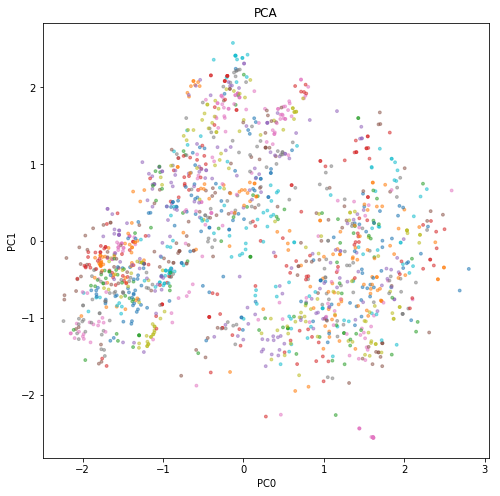

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_pca[:,0], scaffolds_pca[:,1], alpha=0.5, s=8, c=make_colormap_cycle(labels))
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PCA')

Text(0.5, 1.0, 'MDS')

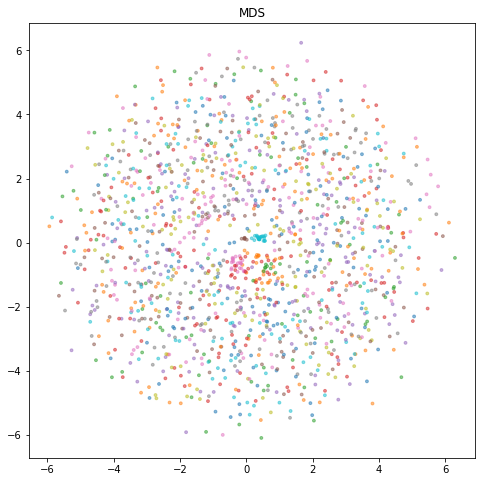

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(scaffold_mds[:,0], scaffold_mds[:,1], alpha=0.5, s=8, c=make_colormap_cycle(labels))
plt.title('MDS')

Text(0.5, 1.0, 'tSNE')

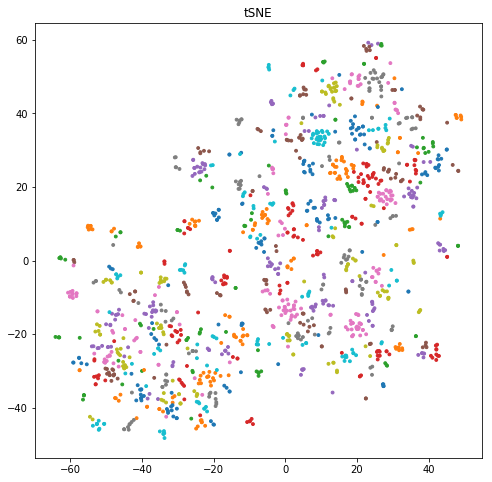

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_tsne[:,0], scaffolds_tsne[:,1], alpha=1.0, s=8, c=make_colormap_cycle(labels))
plt.title('tSNE')

t-SNE is just the best. Here we can see that 1) the clustering works and neighboring points are in the same cluster, 2) that t-SNE is very good at projecting to 2D compared to PCA and MDS.

## Visualizing some clusters

We randomply pick few clusters and visualize the corresponding scaffolds.

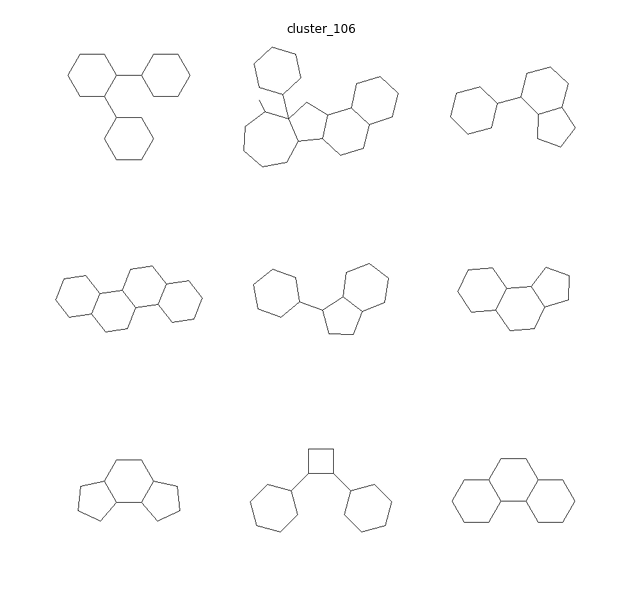

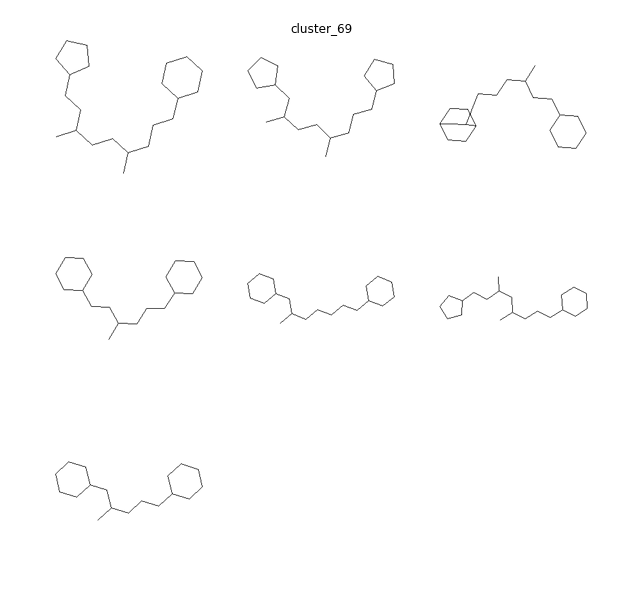

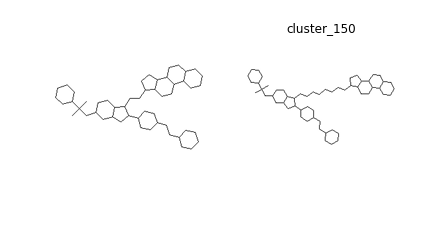

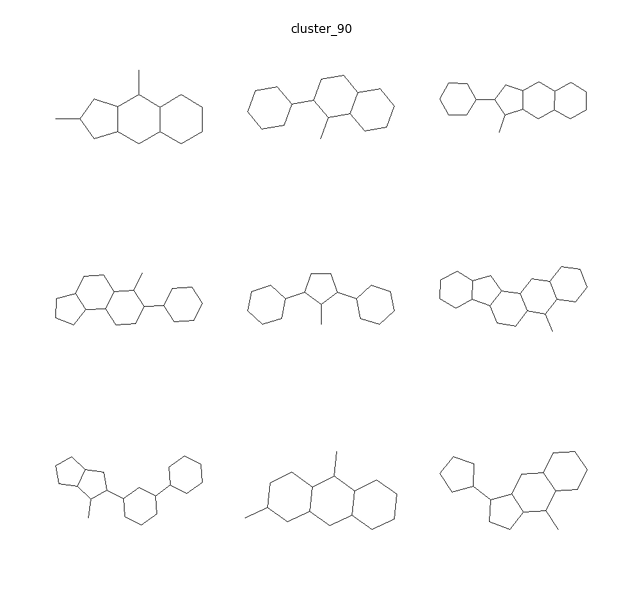

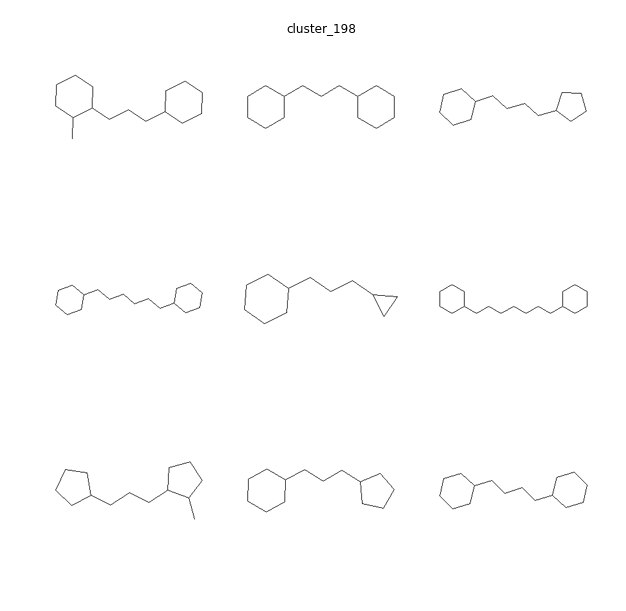

In [31]:
np.random.seed(12)
for c in np.random.choice(label_names,size=5,replace=False):
    mols = df_scaffolds.query('cluster_label == "%s"' % c)['mol']
    picked_scaffolds = np.random.choice(mols, size=min(9,len(mols)), replace=False)
#     img = Chem.Draw.MolsToGridImage(picked_scaffolds, subImgSize=(250,250))
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(c)
    for i in range(len(picked_scaffolds)):
        plt.subplot(3,3,i+1)
        img = Chem.Draw.MolToImage(picked_scaffolds[i], fitImage=True)
        plt.axis('off')
        plt.imshow(img, aspect='equal', interpolation='spline16')
    fig.tight_layout()
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

We see that the scaffolds within clusters are quite homogenous.

## Linear regression on cluster labels

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [65]:
df_era = df_activity \
    .join(df_molecules_std, on='std_inchi_key') \
    .join(df_scaffolds.set_index('scaffold_inchi_key'), on='scaffold_inchi_key', lsuffix='_l') \
    .rename(lambda x:x.replace('pChEMBL_Value', 'activity'), axis='columns') \
    .query('receptor_name == "ERa"') \
    .copy()

In [66]:
cluster_labels_oh = OneHotEncoder().fit_transform(df_era.cluster_label.values.reshape(-1,1))

In [67]:
lr = LinearRegression()
lr.fit(cluster_labels_oh, df_era.activity)
r2 = lr.score(cluster_labels_oh, df_era.activity)
np.sqrt(r2)

0.7508554823027506

This shows that we can model the activity quite well based just on the membership to one of the 200 clusters.

## Save the output

We save the cluster labels for the future

In [32]:
df_scaffolds.to_csv('secondary_data/df_scaffolds.csv')